In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from PropensityScoreMatching import propension_score_matching
import pandas as pd 
import numpy as np 

L’évaluation a posteriori de l’effet d'un traitement sur une population nécessite d’établir un contrefactuel pertinent. Pour cela, il est nécessaire de trouver un groupe d'individus observées aussi proches que possibles des bénéficiaires. 
Il sera alors possible de réaliser une double différence, i.e. d’apprécier dans quelle mesure l’évolution du groupe traité diverge de celle du groupe de contrôle après la mise en œuvre de la mesure de crédit d’impôt que l’on veut évaluer. Pour être valable, une telle analyse requiert que soit vérifiée l’hypothèse de « tendances parallèles » selon laquelle les deux groupes auraient évolué de la même manière en l’absence de traitement.*

L’appariement par score de propension permet de retrouver des entreprises non bénéficiaires aux caractéristiques proches de bénéficiaires. 
Cette méthode repose sur l’estimation de la probabilité d’être traitée (ou score de propension) en fonction de différentes caractéristiques économiques ou géographiques, puis sur un appariement entre les individus traités et témoins, dont la propension à bénéficier du traitement est la plus proche, sous la contrainte qu’ils présentent certaines caractéristiques communes.



### <center> **Création d'un dataframe de test**

In [5]:
data = {'id': [], 'treatment': [], 'CA': [], 'EBE': [], 'annee': []}

for id in range(1000):
    year_of_treatment = np.random.randint(2015, 2020)
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(1 if year == year_of_treatment else 0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

for id in range(1001, 3000):
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

df = pd.DataFrame(data)

In [4]:
df

,id,treatment,CA,EBE,annee
0,0,1,-2.117022,-1.000675,2015
1,0,0,0.511688,0.400060,2016
2,0,0,-1.096076,-1.247812,2017
3,0,0,-2.420417,1.707856,2018
4,0,0,-0.898315,-0.643562,2019
...,...,...,...,...,...
14990,2999,0,-1.296605,0.885781,2015
14991,2999,0,0.274775,1.203617,2016
14992,2999,0,1.016081,-0.189101,2017
14993,2999,0,1.025972,-2.007914,2018


### <center> **`initialisation du matcher`**

*La première étape consiste à initialiser le matcher en choisissant le ratio d'individus de contrôle par individus traités, préciser la variable qui indique le traitement, la variable de temporalité si on est en présence de séries temporelles, et la variable d'id permettant de distinguer les individus.*

In [9]:
matcher = propension_score_matching.PropensityScoreMatcher(ratio=1, var_treatment="treatment", time_series_var="annee", id_var="id")

### <center> **`Fit du Logit`**

Une fois le matcher initialisé, la première étape de la méthode peut être implémentée : le calcul du score de propension. Une regression logisitique est ainsi estimée sur la variable de traitement à partir de variables précisées en input. 


In [10]:
df = matcher.fit_logit_on_df(df, ['CA', 'EBE'])

Optimization terminated successfully.
         Current function value: 0.244942
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                14995
Model:                          Logit   Df Residuals:                    14992
Method:                           MLE   Df Model:                            2
Date:                Wed, 03 Apr 2024   Pseudo R-squ.:               0.0001893
Time:                        10:54:09   Log-Likelihood:                -3672.9
converged:                       True   LL-Null:                       -3673.6
Covariance Type:            nonrobust   LLR p-value:                    0.4988
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6396      0.033    -80.573      0.000      -2.704      -2.575
CA             0.0167      0.

Il convient de vérifier qu'il existe un support commun du score de propension entre les deux groupes avant le matching. Si tel n'était pas le cas, alors une ou plusieurs variabels prises en compte dans la regression logisitque permettraient de distinguer clairement les traités des non-traités. La méthode ne pourrait pas être appliquée en l'état car il ne serait pas posisble de trouver des individus aux caractérsitiques similaires n'ayant pas été traités. 

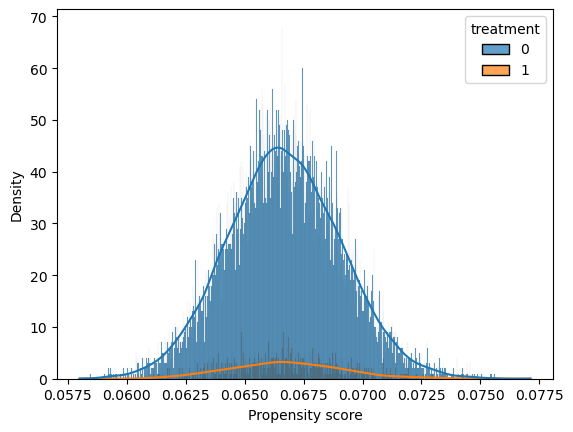

In [8]:
matcher.check_plot_common_support(df)

### <center> **`Matching`**

Une fois l'évaluation du score de propesnion effectuée, le matching peut être realisé. Ici, une variable est ultisée comme cindition exacte de matching, ie, pour un idnividu traité en année t, un individu non-traité est recherché selon les caracétrisitues en année t. La recherche d'un individu proche est donc réalisée au sein d'un échantillon restreint.

In [11]:
df_matched = matcher.match(df, exact_matching=['annee'])

Processing to matching row by row: 100%|██████████| 14995/14995 [00:03<00:00, 4113.91it/s] 


In [ ]:
matcher.report()

In [14]:
df_matched

,id,treatment,CA,EBE,annee,propensity_score,annee_treatment,treatment_period,treated_over_time,matched_id,to_keep_after_matching
0,0,0,-0.959982,-1.000248,2015,0.063567,2016.0,-1.0,1,[1966],1.0
1,0,1,-0.001798,0.647582,2016,0.068033,2016.0,0.0,1,[1966],1.0
2,0,0,-0.522217,-0.114128,2017,0.065854,2016.0,1.0,1,[1966],1.0
3,0,0,-1.026335,-0.040639,2018,0.065494,2016.0,2.0,1,[1966],1.0
4,0,0,-1.048321,1.415083,2019,0.068604,2016.0,3.0,1,[1966],1.0
...,...,...,...,...,...,...,...,...,...,...,...
14990,2999,0,0.728231,0.807315,2015,0.069162,NaN,NaN,0,NaN,0.0
14991,2999,0,-0.351422,0.209832,2016,0.066720,NaN,NaN,0,NaN,0.0
14992,2999,0,1.206463,0.209935,2017,0.068356,NaN,NaN,0,NaN,0.0
14993,2999,0,0.051924,-0.942796,2018,0.064698,NaN,NaN,0,NaN,0.0


In [20]:
df_analysis = matcher.get_dataframe_for_analysis(df_matched)

In [21]:
df_analysis

,id,treatment,CA,EBE,annee,propensity_score,annee_treatment,treatment_period,treated_over_time,matched_id,to_keep_after_matching
0,0,0,-0.959982,-1.000248,2015,0.063567,2016.0,-1.0,1,[1966],1.0
1,0,1,-0.001798,0.647582,2016,0.068033,2016.0,0.0,1,[1966],1.0
2,0,0,-0.522217,-0.114128,2017,0.065854,2016.0,1.0,1,[1966],1.0
3,0,0,-1.026335,-0.040639,2018,0.065494,2016.0,2.0,1,[1966],1.0
4,0,0,-1.048321,1.415083,2019,0.068604,2016.0,3.0,1,[1966],1.0
...,...,...,...,...,...,...,...,...,...,...,...
13175,2636,0,-0.614053,1.422448,2015,0.069084,NaN,NaN,0,NaN,1.0
13176,2636,0,1.114935,0.719341,2016,0.069383,NaN,NaN,0,NaN,1.0
13177,2636,0,1.176034,-0.192662,2017,0.067448,NaN,NaN,0,NaN,1.0
13178,2636,0,0.914836,1.887624,2018,0.071801,NaN,NaN,0,NaN,1.0
